In [3]:

import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
import numpy as np
import random
import optuna


C:\Users\Afari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()


In [5]:

train_dir = r"C:\Users\Afari\Downloads\archive (3)\Training"
test_dir = r"C:\Users\Afari\Downloads\archive (3)\Testing"

transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

full_train_dataset = datasets.ImageFolder(train_dir, transform=transform['train'])
val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(test_dir, transform=transform['val'])

loaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False)
}


In [6]:

def train_model(model, criterion, optimizer, loader, device):
    model.train()
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate_model(model, loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return accuracy_score(targets, preds)


In [7]:

def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    model = models.alexnet(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False

    num_classes = len(full_train_dataset.classes)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer_class = getattr(torch.optim, optimizer_name)
    optimizer = optimizer_class(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    for epoch in range(5):
        train_model(model, criterion, optimizer, loaders['train'], device)

    val_acc = evaluate_model(model, loaders['val'], device)
    return 1.0 - val_acc


In [8]:

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {1.0 - trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
    
    


[I 2025-04-11 14:35:08,490] A new study created in memory with name: no-name-6565249f-fb19-4bc6-b3e1-a14acbf023a1
C:\Users\Afari\AppData\Local\Temp\ipykernel_12372\1858472165.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
C:\Users\Afari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Afari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' 

Best trial:
  Accuracy: 0.9466
  Best hyperparameters:
    lr: 0.0005252406938099485
    optimizer: Adam


In [9]:

import shap
import cv2
import matplotlib.pyplot as plt






In [ ]:
# Rebuild best model from Optuna
best_lr = trial.params['lr']
best_optimizer_name = trial.params['optimizer']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.alexnet(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(full_train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_class = getattr(torch.optim, best_optimizer_name)
optimizer = optimizer_class(filter(lambda p: p.requires_grad, model.parameters()), lr=best_lr)



C:\Users\Afari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Afari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Retrain best model on training dataset
for epoch in range(5):
    train_model(model, criterion, optimizer, loaders['train'], device)



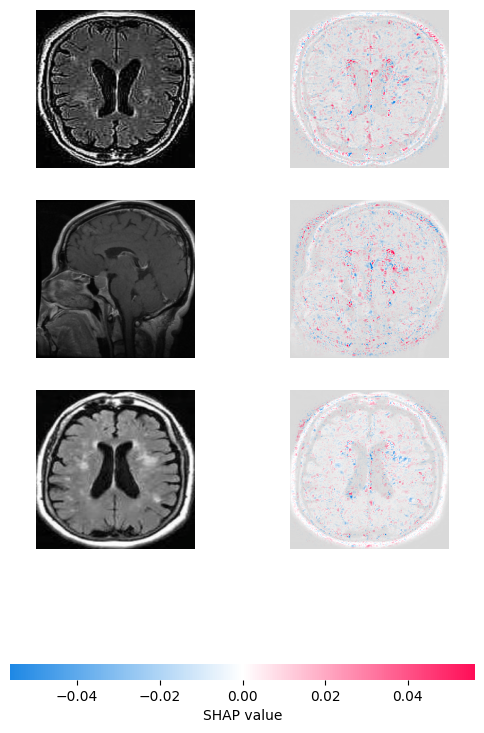

In [ ]:
# SHAP Explanation
model.eval()
background = next(iter(loaders['train']))[0][:3].to(device)
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(background)

shap_image_values = shap_values[0]
pixel_values = background.cpu().numpy().transpose(0, 2, 3, 1)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
pixel_values = (pixel_values * std) + mean
pixel_values = np.clip(pixel_values, 0, 1)

shap.image_plot(shap_image_values, pixel_values)



In [ ]:
# Grad-CAM visualization
def generate_gradcam(model, image_tensor, class_idx):
    model.eval()
    features_blobs = []

    def hook_feature(module, input, output):
        features_blobs.append(output)

    finalconv_name = 'features'
    handle = model._modules.get(finalconv_name)[12].register_forward_hook(hook_feature)

    output = model(image_tensor.to(device))
    params = list(model.classifier.parameters())
    weight_softmax = params[-2].detach().cpu().numpy()
    feature_map = features_blobs[0].squeeze(0).cpu().detach().numpy()
    class_weights = weight_softmax[class_idx]

    cam = np.zeros(feature_map.shape[1:], dtype=np.float32)
    for i in range(len(class_weights[:feature_map.shape[0]])):
        cam += class_weights[i] * feature_map[i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    handle.remove()
    return heatmap



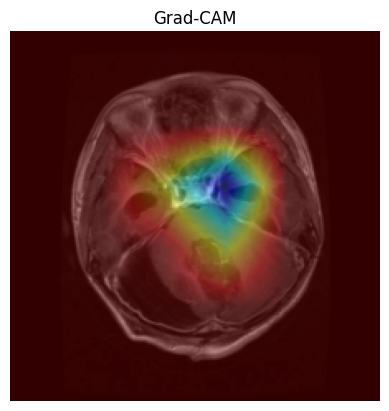

In [14]:
# Visualize Grad-CAM on one test image
first_img, _ = next(iter(loaders['test']))
first_img_tensor = first_img[0].unsqueeze(0).to(device)
pred = model(first_img_tensor)
class_idx = torch.argmax(pred).item()
heatmap = generate_gradcam(model, first_img_tensor, class_idx)

original = first_img[0].permute(1, 2, 0).numpy()
original = (original * std) + mean
original = np.clip(original, 0, 1)
original = np.uint8(original * 255)
overlaid = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)

plt.imshow(overlaid)
plt.title("Grad-CAM")
plt.axis('off')
plt.show()
